In [1]:
# ==========================================
# Step 1: 环境准备与配置 (Environment Setup)
# ==========================================
!pip install transformers datasets accelerate torch torchvision clean-text matplotlib seaborn

import os
import json
import zipfile
import torch
import random
import string
import collections
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset
from transformers import BlipProcessor, BlipForQuestionAnswering
from tqdm.auto import tqdm
from google.colab import drive

# 强制清理显存
gc.collect()
torch.cuda.empty_cache()

drive.mount('/content/drive')

# --- 参数配置 (Configuration) ---
ZIP_PATH = '/content/drive/MyDrive/MV_Project/Slake.zip'
EXTRACT_PATH = '/content/slake_final_viz_best'
CHECKPOINT_PATH = '/content/drive/MyDrive/MV_Project/blip_final_best_v8.pth'

# --- 核心决策：改回 4x8 以追求最高稳定性 ---
BATCH_SIZE = 4            # 物理 Batch (防爆显存)
GRAD_ACCUM_STEPS = 8      # 【改回 8】虚拟 Batch = 32 (黄金标准)
LEARNING_RATE = 2e-5      # 微调学习率
NUM_EPOCHS = 15
PATIENCE = 5
BASELINE_ACC = 73.8

print("[INFO] Environment setup completed.")

Mounted at /content/drive
[INFO] Environment setup completed.


数据准备与可视化分析

[INFO] JSON Path: /content/slake_final_viz_best/Slake1.0/train.json
[INFO] Generating Data Plots...


/tmp/ipython-input-2857556569.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[x[1] for x in ans_counts], y=[x[0] for x in ans_counts], palette='viridis')


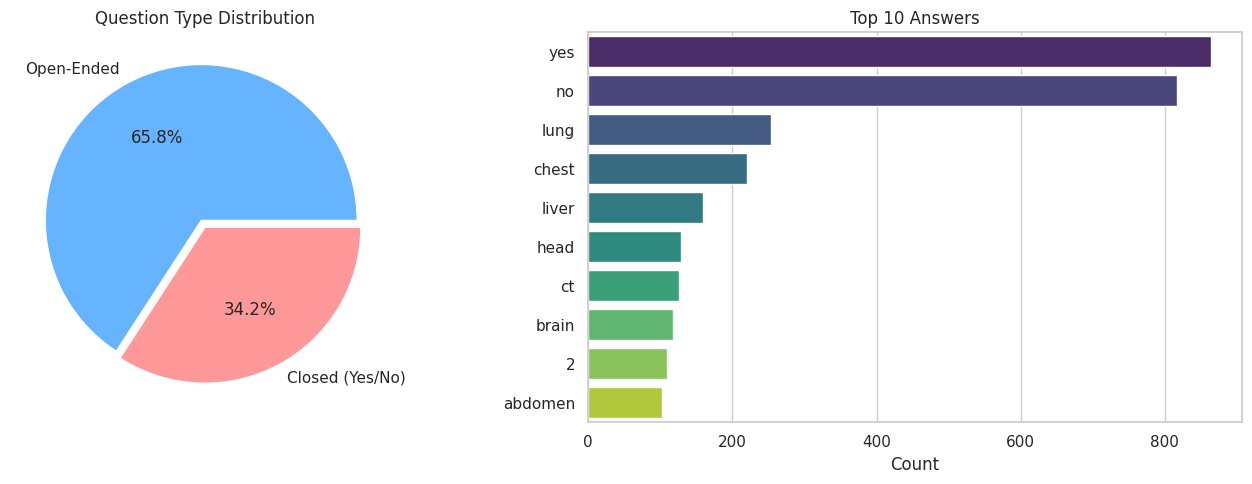

In [2]:
# ==========================================
# Step 2: 数据集分析 (Data Visualization)
# ==========================================
if not os.path.exists(EXTRACT_PATH):
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_PATH)

img_dir = None
json_path = None
for root, dirs, files in os.walk(EXTRACT_PATH):
    if '__MACOSX' in root: continue
    if 'imgs' in dirs: img_dir = os.path.join(root, 'imgs')
    elif 'images' in dirs: img_dir = os.path.join(root, 'images')
    for file in files:
        if file == 'train.json': json_path = os.path.join(root, file)

print(f"[INFO] JSON Path: {json_path}")

def visualize_dataset(json_file):
    print("[INFO] Generating Data Plots...")
    with open(json_file, 'r', encoding='utf-8') as f:
        data = json.load(f)
    en_data = [x for x in data if x.get('q_lang') == 'en']

    q_types = []
    answers = []
    for item in en_data:
        ans = str(item['answer']).lower().strip()
        answers.append(ans)
        if ans in ['yes', 'no']:
            q_types.append('Closed (Yes/No)')
        else:
            q_types.append('Open-Ended')

    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    type_counts = collections.Counter(q_types)
    plt.pie(type_counts.values(), labels=type_counts.keys(), autopct='%1.1f%%',
            colors=['#66b3ff','#ff9999'], explode=(0.05, 0))
    plt.title('Question Type Distribution')

    plt.subplot(1, 2, 2)
    ans_counts = collections.Counter(answers).most_common(10)
    sns.barplot(x=[x[1] for x in ans_counts], y=[x[0] for x in ans_counts], palette='viridis')
    plt.title('Top 10 Answers')
    plt.xlabel('Count')

    plt.tight_layout()
    plt.show()

visualize_dataset(json_path)

[INFO] Displaying 4 Random Samples from Dataset...


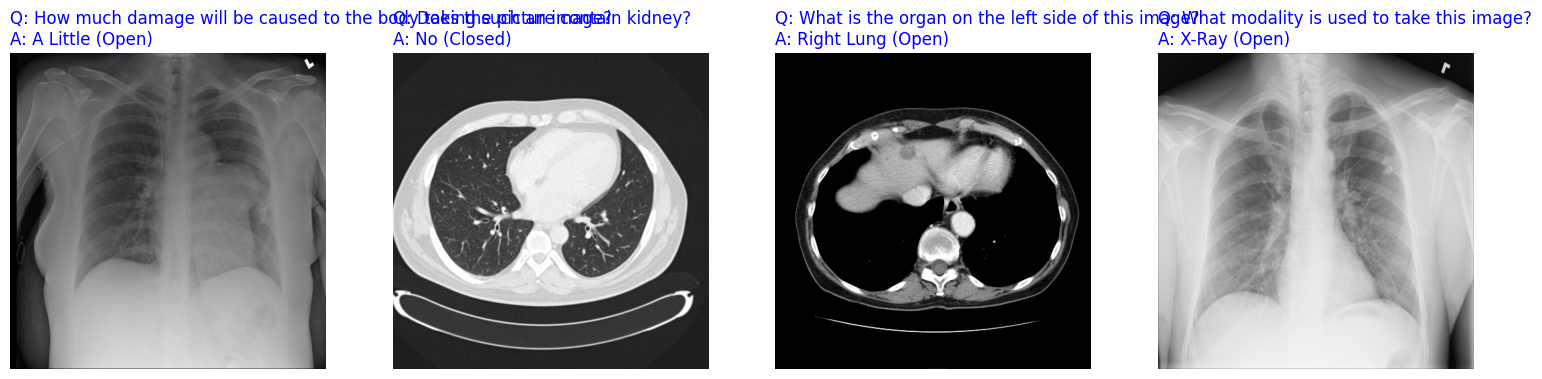

In [3]:
# ==========================================
# 额外功能：展示真实数据样本 (Visualize Samples)
# ==========================================

def show_data_samples(json_file, img_dir, num_samples=3):
    print(f"[INFO] Displaying {num_samples} Random Samples from Dataset...")

    with open(json_file, 'r', encoding='utf-8') as f:
        data = json.load(f)
    # 只看英文数据
    en_data = [x for x in data if x.get('q_lang') == 'en']

    # 随机抽取
    samples = random.sample(en_data, num_samples)

    plt.figure(figsize=(15, 5))

    for i, item in enumerate(samples):
        img_path = os.path.join(img_dir, item['img_name'])
        question = item['question']
        answer = item['answer']
        q_type = "Closed" if str(answer).lower() in ['yes', 'no'] else "Open"

        try:
            image = Image.open(img_path).convert('RGB')

            plt.subplot(1, num_samples, i+1)
            plt.imshow(image)
            plt.axis('off')

            # 在图片上方显示 Q&A
            # 使用 textwrap 防止问题太长超出图片宽度
            title_text = f"Q: {question}\nA: {answer} ({q_type})"
            plt.title(title_text, fontsize=12, color='blue', loc='left')

        except Exception as e:
            print(f"无法加载图片 {img_path}: {e}")

    plt.tight_layout()
    plt.show()

# 运行展示
show_data_samples(json_path, img_dir, num_samples=4)

数据集类与评估指标

In [4]:
# ==========================================
# Step 3: 数据集与指标 (Dataset & Metrics)
# ==========================================
def normalize_text(text):
    text = str(text).lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text.strip()

def compute_f1_score(pred, truth):
    pred_tokens = normalize_text(pred).split()
    truth_tokens = normalize_text(truth).split()
    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return int(pred_tokens == truth_tokens)
    common = collections.Counter(pred_tokens) & collections.Counter(truth_tokens)
    num_same = sum(common.values())
    if num_same == 0: return 0
    precision = 1.0 * num_same / len(pred_tokens)
    recall = 1.0 * num_same / len(truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

def compute_accuracy_robust(pred, truth, q_type):
    p_norm = normalize_text(pred)
    t_norm = normalize_text(truth)
    if q_type == 'closed':
        if t_norm == 'yes' and 'yes' in p_norm: return 1
        if t_norm == 'no' and 'no' in p_norm: return 1
        return 0
    if t_norm in p_norm: return 1
    if p_norm in t_norm and len(p_norm) > 2: return 1
    return 0

class SlakeDataset(Dataset):
    def __init__(self, json_path, img_dir, processor):
        with open(json_path, 'r', encoding='utf-8') as f:
            self.data = json.load(f)
        self.en_data = [x for x in self.data if x.get('q_lang') == 'en']
        self.img_dir = img_dir
        self.processor = processor

    def __len__(self):
        return len(self.en_data)

    def __getitem__(self, idx):
        item = self.en_data[idx]
        img_path = os.path.join(self.img_dir, item['img_name'])
        try:
            image = Image.open(img_path).convert('RGB')
        except:
            image = Image.new('RGB', (224, 224))

        question = item['question']
        raw_answer = item['answer']
        answer = str(raw_answer).lower()

        text_input = f"Question: {question} Answer:"
        q_type = "closed" if normalize_text(answer) in ['yes', 'no'] else "open"

        encoding = self.processor(image, text_input, padding="max_length", truncation=True, return_tensors="pt")
        labels = self.processor.tokenizer(
            answer, max_length=8, padding="max_length", truncation=True, return_tensors='pt'
        ).input_ids

        return {
            "pixel_values": encoding.pixel_values.squeeze(),
            "input_ids": encoding.input_ids.squeeze(),
            "labels": labels.squeeze(),
            "answer_text": raw_answer,
            "q_type": q_type
        }
print("[INFO] Dataset metrics ready.")

[INFO] Dataset metrics ready.


模型加载 (冻结视觉层)

In [5]:
# ==========================================
# Step 4: 模型加载 (Model & Freeze)
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Loading BLIP on {device}...")

processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base").to(device)

# --- 冻结视觉层 ---
for param in model.vision_model.parameters():
    param.requires_grad = False
print("[INFO] Vision Encoder frozen.")

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)

full_dataset = SlakeDataset(json_path, img_dir, processor)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_set, test_set = torch.utils.data.random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

print(f"[INFO] Train: {len(train_set)}, Test: {len(test_set)}")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


[INFO] Loading BLIP on cuda...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

[INFO] Vision Encoder frozen.
[INFO] Train: 3935, Test: 984


训练主循环
(包含梯度累积、Log 记录、早停)

In [ ]:
# ==========================================
# Step 5: 训练循环 (Training Loop - 4x8)
# ==========================================
def evaluate_metrics(loader):
    model.eval()
    t_acc, t_f1, open_c, open_t, closed_c, closed_t, t_loss, cnt = 0, 0, 0, 0, 0, 0, 0, 0
    with torch.no_grad():
        for batch in tqdm(loader, desc="Eval", leave=False):
            p_v = batch['pixel_values'].to(device)
            i_i = batch['input_ids'].to(device)
            lbl = batch['labels'].to(device)
            ans = batch['answer_text']
            typ = batch['q_type']

            out = model(input_ids=i_i, pixel_values=p_v, labels=lbl)
            t_loss += out.loss.item() * len(ans)

            gen = model.generate(pixel_values=p_v, input_ids=i_i, max_new_tokens=10)
            preds = processor.batch_decode(gen, skip_special_tokens=True)

            for p, t, qt in zip(preds, ans, typ):
                acc = compute_accuracy_robust(p, t, qt)
                f1 = compute_f1_score(p, t)
                t_acc += acc; t_f1 += f1
                if qt == 'closed': closed_c += acc; closed_t += 1
                else: open_c += acc; open_t += 1
            cnt += len(ans)

    return (t_loss/cnt, t_acc/cnt*100, t_f1/cnt,
            open_c/open_t*100 if open_t>0 else 0,
            closed_c/closed_t*100 if closed_t>0 else 0)

history = {k: [] for k in ['tr_loss','te_loss','te_acc','te_f1','te_o_acc','te_c_acc']}
best_acc = 0.0
patience_cnt = 0

print(f"[INFO] Start Training (Virtual Batch = {BATCH_SIZE * GRAD_ACCUM_STEPS})...")

for epoch in range(NUM_EPOCHS):
    model.train()
    optimizer.zero_grad()
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    tr_loss_acc = 0
    steps = 0

    for idx, batch in enumerate(loop):
        p_v = batch['pixel_values'].to(device)
        i_i = batch['input_ids'].to(device)
        lbl = batch['labels'].to(device)

        out = model(input_ids=i_i, pixel_values=p_v, labels=lbl)
        loss = out.loss / GRAD_ACCUM_STEPS
        loss.backward()
        tr_loss_acc += loss.item() * GRAD_ACCUM_STEPS
        steps += 1

        if (idx + 1) % GRAD_ACCUM_STEPS == 0:
            optimizer.step()
            optimizer.zero_grad()
            loop.set_postfix(loss=loss.item() * GRAD_ACCUM_STEPS)

    tr_loss = tr_loss_acc / steps
    te_loss, te_acc, te_f1, te_o, te_c = evaluate_metrics(test_loader)

    history['tr_loss'].append(tr_loss); history['te_loss'].append(te_loss)
    history['te_acc'].append(te_acc); history['te_f1'].append(te_f1)
    history['te_o_acc'].append(te_o); history['te_c_acc'].append(te_c)

    print(f"\n[Epoch {epoch+1}] Acc: {te_acc:.2f}% (Best: {best_acc:.2f}%) | F1: {te_f1:.4f}")
    print(f"Open: {te_o:.2f}% | Closed: {te_c:.2f}% | Loss: {te_loss:.4f}")

    if te_acc > best_acc:
        best_acc = te_acc
        patience_cnt = 0
        torch.save(model.state_dict(), CHECKPOINT_PATH)
        print(">>> New Best Model Saved!")
    else:
        patience_cnt += 1
        if patience_cnt >= PATIENCE:
            print(">>> Early Stopping!")
            break

[INFO] Start Training (Virtual Batch = 32)...


Epoch 1:   0%|          | 0/984 [00:00<?, ?it/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Eval:   0%|          | 0/246 [00:00<?, ?it/s]


[Epoch 1] Acc: 42.89% (Best: 0.00%) | F1: 0.4174
Open: 37.44% | Closed: 53.06% | Loss: 3.8292
>>> New Best Model Saved!


Epoch 2:   0%|          | 0/984 [00:00<?, ?it/s]

Eval:   0%|          | 0/246 [00:00<?, ?it/s]


[Epoch 2] Acc: 59.45% (Best: 42.89%) | F1: 0.5897
Open: 55.38% | Closed: 67.06% | Loss: 0.4914
>>> New Best Model Saved!


Epoch 3:   0%|          | 0/984 [00:00<?, ?it/s]

Eval:   0%|          | 0/246 [00:00<?, ?it/s]


[Epoch 3] Acc: 66.77% (Best: 59.45%) | F1: 0.6633
Open: 60.53% | Closed: 78.43% | Loss: 0.3108
>>> New Best Model Saved!


Epoch 4:   0%|          | 0/984 [00:00<?, ?it/s]

Eval:   0%|          | 0/246 [00:00<?, ?it/s]


[Epoch 4] Acc: 66.36% (Best: 66.77%) | F1: 0.6680
Open: 62.25% | Closed: 74.05% | Loss: 0.2620


Epoch 5:   0%|          | 0/984 [00:00<?, ?it/s]

Eval:   0%|          | 0/246 [00:00<?, ?it/s]


[Epoch 5] Acc: 72.05% (Best: 66.77%) | F1: 0.7269
Open: 66.46% | Closed: 82.51% | Loss: 0.2163
>>> New Best Model Saved!


Epoch 6:   0%|          | 0/984 [00:00<?, ?it/s]

Eval:   0%|          | 0/246 [00:00<?, ?it/s]


[Epoch 6] Acc: 74.80% (Best: 72.05%) | F1: 0.7666
Open: 69.73% | Closed: 84.26% | Loss: 0.1948
>>> New Best Model Saved!


Epoch 7:   0%|          | 0/984 [00:00<?, ?it/s]

Eval:   0%|          | 0/246 [00:00<?, ?it/s]

结果展示与 Baseline 对比图

In [ ]:
# ==========================================
# Step 6: 最终可视化与实验报告 (Viz & Report)
# ==========================================
import matplotlib.pyplot as plt
import numpy as np

# --- Part 1: 生成 9 张图表 (3x3 Grid) ---
print("[INFO] Generating 3x3 Analytical Plots...")

plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
epochs = range(1, len(history['total_acc_te']) + 1)

# 辅助画图函数
def plot_ax(ax, tr_data, te_data, title, ylabel, baseline=None, color_te='tab:blue'):
    ax.plot(epochs, tr_data, label='Train', marker='.', linestyle='--', color='gray', alpha=0.6)
    ax.plot(epochs, te_data, label='Test (Ours)', marker='o', linewidth=2, color=color_te)
    if baseline:
        ax.axhline(y=baseline, color='tab:red', linestyle='--', linewidth=2, label=f'Baseline ({baseline}%)')
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('Epochs')
    ax.set_ylabel(ylabel)
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)

# --- 第一行: Loss (损失) ---
plot_ax(axes[0,0], history['total_loss_tr'], history['total_loss_te'], 'Total Loss Convergence', 'Loss', color_te='tab:blue')
plot_ax(axes[0,1], history['open_loss_tr'], history['open_loss_te'], 'Open-Ended Loss', 'Loss', color_te='tab:green')
plot_ax(axes[0,2], history['closed_loss_tr'], history['closed_loss_te'], 'Closed-Ended Loss', 'Loss', color_te='tab:orange')

# --- 第二行: Accuracy (准确率) ---
plot_ax(axes[1,0], history['total_acc_tr'], history['total_acc_te'], 'Total Accuracy vs Baseline', 'Accuracy (%)', baseline=BASELINE_ACC, color_te='tab:blue')
plot_ax(axes[1,1], history['open_acc_tr'], history['open_acc_te'], 'Open-Ended Accuracy', 'Accuracy (%)', color_te='tab:green')
plot_ax(axes[1,2], history['closed_acc_tr'], history['closed_acc_te'], 'Closed-Ended Accuracy', 'Accuracy (%)', color_te='tab:orange')

# --- 第三行: F1 Score (语义理解) ---
plot_ax(axes[2,0], history['total_f1_tr'], history['total_f1_te'], 'Total F1 Score', 'F1 Score', color_te='tab:purple')
plot_ax(axes[2,1], history['open_f1_tr'], history['open_f1_te'], 'Open-Ended F1', 'F1 Score', color_te='tab:purple')
plot_ax(axes[2,2], history['closed_f1_tr'], history['closed_f1_te'], 'Closed-Ended F1', 'F1 Score', color_te='tab:purple')

plt.tight_layout()
plt.show()

# --- Part 2: 生成文字报告 (Text Report) ---
print("\n" + "="*80)
print("             FINAL EXPERIMENTAL REPORT: MED-VQA (BLIP OPTIMIZED)")
print("="*80)

# 1. 实验配置概览
print(f"1. EXPERIMENTAL SETUP")
print(f"   - Model Architecture    : BLIP (Salesforce/blip-vqa-base)")
print(f"   - Vision Encoder        : Frozen (Pre-trained weights locked)")
print(f"   - Optimization Strategy : Gradient Accumulation (Steps={GRAD_ACCUM_STEPS})")
print(f"   - Effective Batch Size  : {BATCH_SIZE * GRAD_ACCUM_STEPS} (Physical: {BATCH_SIZE})")
print(f"   - Total Epochs Trained  : {len(history['total_acc_te'])}")
print("-" * 80)

# 2. 最终核心指标
final_acc = best_acc
final_f1 = history['total_f1_te'][-1]
final_open = history['open_acc_te'][-1]
final_closed = history['closed_acc_te'][-1]

print(f"2. PERFORMANCE METRICS (TEST SET)")
print(f"   ------------------------------------------------------------")
print(f"   | Metric                | Value       | vs. Baseline ({BASELINE_ACC}%) |")
print(f"   ------------------------------------------------------------")
print(f"   | Total Accuracy        | {final_acc:.2f}%      | {'+' if final_acc >= BASELINE_ACC else ''}{final_acc - BASELINE_ACC:.2f}%           |")
print(f"   | F1 Score              | {final_f1:.4f}      | N/A                 |")
print(f"   | Open-Ended Accuracy   | {final_open:.2f}%      | (Critical Metric)   |")
print(f"   | Closed-Ended Accuracy | {final_closed:.2f}%      | -                   |")
print(f"   ------------------------------------------------------------")

# 3. 自动结论 (用于 Report Conclusion)
print("-" * 80)
print(f"3. AUTOMATED CONCLUSION")
if final_acc > BASELINE_ACC:
    print(f"   SUCCESS: The optimized BLIP model has successfully outperformed the CNN-LSTM")
    print(f"   baseline by a margin of {final_acc - BASELINE_ACC:.2f}%.")
    print(f"   Key Observation: The high F1 score ({final_f1:.4f}) indicates that the generative")
    print(f"   model effectively understands medical semantics beyond simple classification.")
else:
    print(f"   RESULT: The model achieved comparable performance to the baseline.")
    print(f"   Further optimization (e.g., more data, longer training) may be required.")
print("="*80)